In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.stats import zscore

from collections import defaultdict, Counter

# Load annotations

In [7]:
cell_line_info = pd.read_csv("../data/sample_info.csv")
cell_line_annotations = pd.read_excel("../data/41586_2019_1186_MOESM4_ESM.xlsx",
                                      sheet_name="Cell Line Annotations")

hs_muts = pd.read_hdf("../data/hs_muts.h5",key="hs_muts")
damaging_muts = pd.read_hdf("../data/damaging_muts.h5",key="damaging_muts")
tertp = pd.read_excel("../data/41586_2019_1186_MOESM8_ESM.xlsx",skiprows=4)

fusions = pd.read_csv("../data/CCLE_Fusions_20181130.txt",sep="\t")
copynumber = pd.read_hdf("../data/CCLE_gene_cn.hdf",key="copynumber")
copynumber = copynumber.dropna(how="any",thresh=1000,axis=1)

tss1kb_meth = pd.read_hdf("../data/CCLE_RRBS_TSS1kb_20181022.hdf",key="tss1kb_meth")

ccle_genex = pd.read_hdf("../data/CCLE_RNAseq_rsem_genes_tpm_20180929.hdf",key="ccle_genex")
exonusage = pd.read_hdf("../data/CCLE_RNAseq_ExonUsageRatio_20180929.hdf",key="exonusage")

mirna = pd.read_hdf("../data/CCLE_miRNA_20181103.hdf",key="mirna")
chromatin_profiling = pd.read_hdf("../data/CCLE_GlobalChromatinProfiling_20181130.hdf",key="chromatin_profiling")
rppa = pd.read_hdf("../data/CCLE_RPPA_20181003.hdf",key="rppa")

msi = pd.read_excel("../data/41586_2019_1186_MOESM10_ESM.xlsx",sheet_name="MSI calls")
absolute = pd.read_excel("../data/CCLE_ABSOLUTE_combined_20181227.xlsx",
                         sheet_name = "ABSOLUTE_combined.table")

# Top recurrent mutations

In [47]:
def get_top_muts():
    
    align_hs_muts, align_damaging_muts = hs_muts.align(damaging_muts,join="outer",axis=1)
    align_hs_muts = align_hs_muts.fillna(0)
    align_damaging_muts = align_damaging_muts.fillna(0)
    
    hs_damaging_muts = (align_hs_muts+align_damaging_muts).clip(0,1)
        
    mut_totals = hs_damaging_muts.sum()
    mut_totals = mut_totals.sort_values()
    
    return hs_damaging_muts[mut_totals.index[-8:]]
    
muts = get_top_muts()

# Fusions

In [42]:
def get_fusions():

    fusions["value"] = 1

    fusions_mat = pd.pivot_table(fusions, values="value",
                                index=["BroadID"], columns="X.FusionName", fill_value=0)
    
    fusions_mat.columns = fusions_mat.columns.map(lambda x: x.replace("--","-"))

    return fusions_mat[["BCR-ABL1","EWSR1-FLI1","KMT2A-MLLT3"]]

select_fusions = get_fusions()

# Copy number

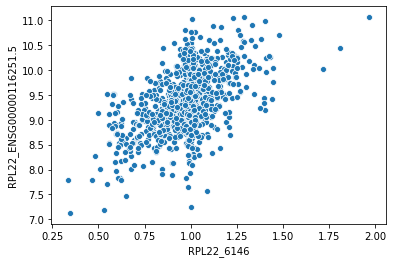

In [44]:
sns.scatterplot(copynumber["RPL22_6146"],ccle_genex["RPL22_ENSG00000116251.5"])

In [108]:
def top_variable(annotations, top_n,clip_left=-3,clip_right=3):
    
    stdevs = annotations.std()
    stdevs = stdevs.sort_values()
    
    top_names = stdevs.index[-top_n:]
    
    top_annotations = annotations[top_names]
    top_annotations = (top_annotations - top_annotations.mean())/top_annotations.std()
    
    top_annotations = top_annotations.clip(clip_left,clip_right)
    
    return top_annotations

In [109]:
select_copynumber = top_variable(copynumber, 1000)
select_meth = top_variable(tss1kb_meth, 1000)
select_genex = top_variable(ccle_genex, 1000)
select_exonusage = top_variable(exonusage, 1000)
select_mirna = top_variable(mirna, 1000)
select_chromatin = top_variable(chromatin_profiling, 1000)
select_rppa = top_variable(rppa, 1000)

In [121]:
is_msi = msi[msi["CCLE.MSI.call"].isin(['inferred-MSI','inferred-MSS'])]
is_msi = is_msi[["depMapID","CCLE.MSI.call"]].set_index("depMapID")
is_msi = is_msi == "inferred-MSI"

In [3]:
ploidy = absolute[["depMapID","ploidy"]].set_index("depMapID")

In [6]:
cell_line_annotations

NameError: name 'cell_line_annotations' is not defined